# **FBT analysis**

**“Frequently Bought Together” (FBT)** analysis finds which products tend to be purchased in the same basket. It’s one of the core techniques behind product recommendations on Amazon, grocery stores, retail POS systems, and e-commerce sites.

There are **7** products in this analysis: **Bread, Butter, Milk, Cereal, Juice, Eggs, and Cheese**

# **⭐ Why businesses use FBT**

*   Increase cross-sell and bundle revenue
*   Improve product placement (store layouts, online page design)
*   Help build promotions (buy X get Y)
*   Identify complementary products
*   Optimize inventory (if A sells out, B might drop too)


# **Method used: Pair Counting**

The pair-count algorithm finds frequently-bought-together items by looking at every shopping basket, listing all item pairs inside it, and counting how often each pair appears.

**Advantages**

*   Fast + Scalable for up to ~100k transactions
*   The simplest and widely used

**Steps**

Group items by transaction

Generate unique combinations (A,B) for each basket

Increment pair counts

Compute:

*   Support(A,B)
*   Confidence
*   Lift

# **FBT test methods comparison**

| Method                   | Best For                 | Pros                 |
| ------------------------ | ------------------------ | -------------------- |
| **Pair-count algorithm** | < 100k transactions      | Easiest, explainable |
| **FP-Growth**            | 100+ products & big data | Very fast            |
| **SQL self-join**        | Data warehouses          | Scalable, simple     |
| **Apriori**              | Bad for >50 products     | Too slow             |


**Import transactions dataset (1,000 transactions)**

In [ ]:
import pandas as pd

transactions_df = pd.read_csv('transactions.csv')
print(transactions_df.head().to_markdown(index=False, numalign="left", stralign="left"))

| TransactionID   | Product   |
|:----------------|:----------|
| 1               | Bread     |
| 1               | Cereal    |
| 1               | Milk      |
| 2               | Butter    |
| 2               | Juice     |


# **fbt pairs dataset**

In [ ]:
fbt_pairs_df = pd.read_csv('fbt_pairs.csv')
print(fbt_pairs_df.head().to_markdown(index=False, numalign="left", stralign="left"))

| ItemA   | ItemB   | Count   | Support   | Confidence(A->B)   | Confidence(B->A)   | Support(B)   | Lift    |
|:--------|:--------|:--------|:----------|:-------------------|:-------------------|:-------------|:--------|
| Butter  | Milk    | 130     | 0.13      | 0.379009           | 0.360111           | 0.361        | 1.04989 |
| Cereal  | Juice   | 138     | 0.138     | 0.382271           | 0.365079           | 0.378        | 1.0113  |
| Cereal  | Eggs    | 134     | 0.134     | 0.371191           | 0.36413            | 0.368        | 1.00867 |
| Juice   | Milk    | 137     | 0.137     | 0.362434           | 0.379501           | 0.361        | 1.00397 |
| Butter  | Juice   | 130     | 0.13      | 0.379009           | 0.343915           | 0.378        | 1.00267 |


**Explain the columns of fbt_pairs dataset:**

✅ 1. **Support**

Definition: **How often the pair (A,B) appears out of all transactions.**

Formula: **Support(𝐴,𝐵) = Count(A,B) / Total Transactions**

✅ 2. **Confidence(A → B)**

Definition: **“How likely customers who buy A also buy B.”**

Formula: **Confidence(𝐴→𝐵) = Count(A,B) / Count(A)**

where **Count(A) = number of transactions containing product A**

✅ 3. **Confidence(B → A)**

**This is the reverse direction.**

Formula: **Confidence(𝐵→𝐴) = Count(A,B) / Count(B)**

✅ 4. **Support(B)**

**You need support of item B by itself.**

Formula: **Support(𝐵) = Count(B) / Total Transactions**

✅ 5. **Lift**

Definition: **Lift measures how much more often A and B occur together compared to random chance.**

Formula: **Lift(𝐴→𝐵) = Confidence(𝐴→𝐵) / Support(𝐵)**

**Interpretation:**

*   Lift > 1 → A & B are positively associated
*   Lift = 1 → independent
*   Lift < 1 → negatively associated

📌 **Example Calculation (from the dataset)**

**Suppose:**

Count(A,B) = 130

Count(A) = 343

Count(B) = 361

Total transactions = 1000

**Then:**

Support = 130 / 1000 = 0.130

Confidence(A→B) = 130 / 343 = 0.379

Confidence(B→A) = 130 / 361 = 0.360

Support(B) = 361 / 1000 = 0.361

**Lift = 0.379 / 0.361 = 1.05**

# **Product Pair Co-occurrence Count Heatmap**

It visually represents how many times each pair of products appeared together in the same transaction within your transactions_df.

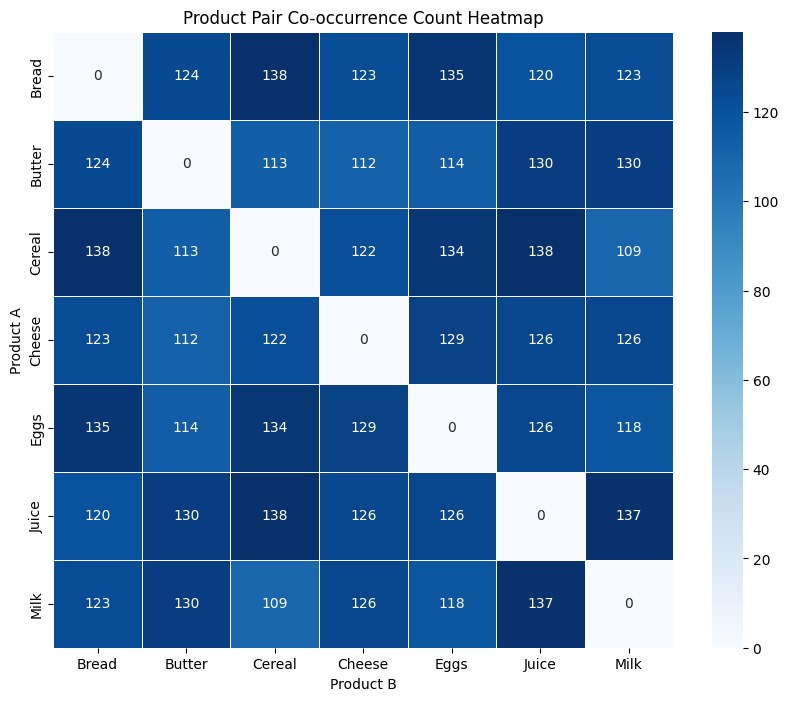

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# Group products by transaction ID
grouped_transactions = transactions_df.groupby('TransactionID')['Product'].apply(list)

# Generate all unique pairs within each transaction
all_pairs = []
for products_in_transaction in grouped_transactions:
    # Sort products to ensure consistent pair representation (e.g., ('A', 'B') instead of ('B', 'A'))
    sorted_products = sorted(products_in_transaction)
    for pair in combinations(sorted_products, 2):
        all_pairs.append(pair)

# Count the occurrences of each unique pair
pair_counts = Counter(all_pairs)

# Get all unique products to define matrix dimensions
all_unique_products = sorted(transactions_df['Product'].unique())

# Initialize a symmetric co-occurrence matrix with zeros
co_occurrence_matrix = pd.DataFrame(0, index=all_unique_products, columns=all_unique_products)

# Populate the co-occurrence matrix
for (item1, item2), count in pair_counts.items():
    co_occurrence_matrix.loc[item1, item2] = count
    co_occurrence_matrix.loc[item2, item1] = count # Ensure symmetry for the heatmap

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='g', cmap='Blues', linewidths=.5)
plt.title('Product Pair Co-occurrence Count Heatmap')
plt.xlabel('Product B')
plt.ylabel('Product A')
plt.show()

# **Here's how to interpret it:**

**Axes:** Both the X-axis (Product B) and Y-axis (Product A) list the unique products in the dataset (Bread, Butter, Cereal, Cheese, Eggs, Juice, Milk).

**Colors and Numbers:** Each cell in the heatmap contains a number, which is the exact count of how many times the product on the Y-axis and the product on the X-axis were bought together. The color intensity also reflects this count: darker blue indicates a higher co-occurrence count, while lighter blue indicates a lower count.

**Diagonal:** The diagonal cells are 0. This is because the heatmap is showing pairs of distinct products, and a product doesn't form a pair with itself in this context.

**Symmetry:** The matrix is symmetric, meaning the value for (Product A, Product B) is the same as (Product B, Product A).

For example, looking at the heatmap, you can see that Cereal and Juice co-occur 138 times, and Bread and Cereal also co-occur 138 times, making them some of the most frequently bought-together pairs in your dataset.

# **Network graph (FBT connections)**

Create a network graph using `networkx` based on the `fbt_pairs_df` DataFrame to visualize product associations.

## Filter FBT pairs for network graph

Filter the pairs to include only those with a `Lift` greater than 1 (positively associated) and a `Count` of at least 100.

Products should be represented as nodes, and co-occurrences as edges.

The edges should be weighted by the `Lift` metric. Display the graph using `matplotlib`, with nodes labeled by product names and customized edge widths based on the 'Lift' value.

In [ ]:
filtered_fbt_pairs_df = fbt_pairs_df[(fbt_pairs_df['Lift'] > 1) & (fbt_pairs_df['Count'] >= 100)]
print(filtered_fbt_pairs_df.head().to_markdown(index=False, numalign="left", stralign="left"))

| ItemA   | ItemB   | Count   | Support   | Confidence(A->B)   | Confidence(B->A)   | Support(B)   | Lift    |
|:--------|:--------|:--------|:----------|:-------------------|:-------------------|:-------------|:--------|
| Butter  | Milk    | 130     | 0.13      | 0.379009           | 0.360111           | 0.361        | 1.04989 |
| Cereal  | Juice   | 138     | 0.138     | 0.382271           | 0.365079           | 0.378        | 1.0113  |
| Cereal  | Eggs    | 134     | 0.134     | 0.371191           | 0.36413            | 0.368        | 1.00867 |
| Juice   | Milk    | 137     | 0.137     | 0.362434           | 0.379501           | 0.361        | 1.00397 |
| Butter  | Juice   | 130     | 0.13      | 0.379009           | 0.343915           | 0.378        | 1.00267 |


The previous step successfully filtered the `fbt_pairs_df` to `filtered_fbt_pairs_df` based on the specified criteria. Now, I need to create a network graph from this `filtered_fbt_pairs_df` using `networkx` and visualize it using `matplotlib`. This involves importing the necessary libraries, initializing a graph, adding nodes (products), and adding edges with 'Lift' as weights.



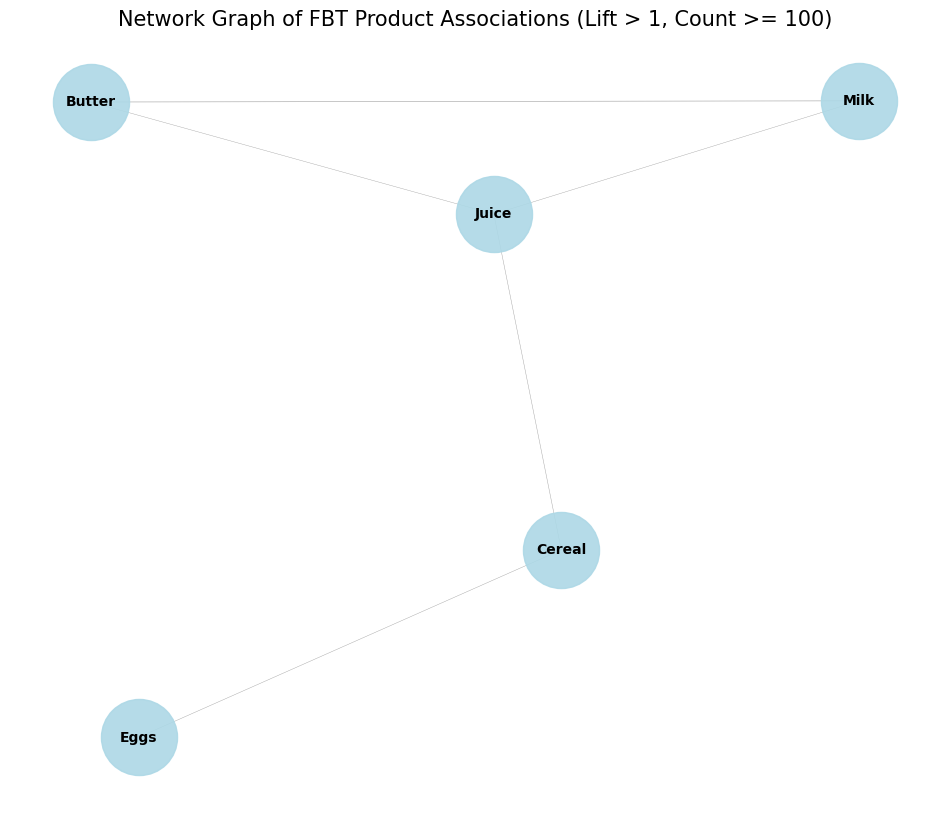

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes and edges from the filtered DataFrame
for index, row in filtered_fbt_pairs_df.iterrows():
    itemA = row['ItemA']
    itemB = row['ItemB']
    lift = row['Lift']

    # Add nodes if they don't exist
    if itemA not in G:
        G.add_node(itemA)
    if itemB not in G:
        G.add_node(itemB)

    # Add edge with 'Lift' as weight
    # Scale lift to make edge widths more visible
    scaled_lift = (lift - filtered_fbt_pairs_df['Lift'].min() + 0.1) * 3 # Add a small offset to avoid very thin lines
    G.add_edge(itemA, itemB, weight=scaled_lift)

# Draw the graph
plt.figure(figsize=(12, 10))

# Position nodes using a spring layout
pos = nx.spring_layout(G, k=0.8, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.9)

# Draw edges with widths based on 'Lift'
edges = G.edges(data=True)
edgewidths = [d['weight'] for u, v, d in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edgewidths, edge_color='gray', alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Network Graph of FBT Product Associations (Lift > 1, Count >= 100)', size=15)
plt.axis('off') # Hide axes
plt.show()


## **Summary:**

### **Data Analysis Key Findings**
*   The `fbt_pairs_df` DataFrame was filtered to include only product associations where the `Lift` value was greater than 1 and the `Count` was at least 100.
*   A network graph was successfully generated where products are represented as nodes and co-occurrences as edges.
*   Edge widths in the graph are customized based on the `Lift` metric, with higher `Lift` values resulting in thicker edges, visually indicating stronger associations. The `Lift` values were scaled to improve visibility.
*   The nodes are labeled with product names, and a spring layout was used to arrange the nodes for better visualization of clusters and connections.




# **Suggested Product Bundles based on High Lift Values**

In [ ]:
top_bundles = filtered_fbt_pairs_df.sort_values(by='Lift', ascending=False).head(5)
print("Top 5 Product Bundles by Lift:\n")
for index, row in top_bundles.iterrows():
    print(f"  - {row['ItemA']} and {row['ItemB']} (Lift: {row['Lift']:.2f})")

Top 5 Product Bundles by Lift:

  - Butter and Milk (Lift: 1.05)
  - Cereal and Juice (Lift: 1.01)
  - Cereal and Eggs (Lift: 1.01)
  - Juice and Milk (Lift: 1.00)
  - Butter and Juice (Lift: 1.00)


These suggestions are based on the highest 'Lift' values, indicating the strongest positive associations between products. Businesses can leverage these insights for:

*   **Promotional Bundles:** Offer 'Cereal and Eggs' as a breakfast combo.
*   **Product Placement:** Place 'Butter' near 'Milk' in a store.
*   **Recommendation Systems:** Suggest 'Juice' to customers who buy 'Cereal'.